# Watershedding on a ZYX shape image


Import packages to open and view tiffile, other python packages to deal with loading images from a certain directory. For writting results we need to create another directory, this is done by pathlib. Local function definations are included in the utils.py file which is imported along with other python packages

In [1]:
from tifffile import imread
import matplotlib.pyplot as plt
import os
import sys
from utils import NormalizeFloat, save_tiff_imagej_compatible,WatershedImage, WatershedImageMarker,BackGroundCorrection,MedianFilter
import glob
import numpy as np
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import Range1d
try:
    from pathlib import Path
    Path().expanduser()
except (ImportError, AttributeError):
        from pathlib2 import Path

try:
        import tempfile
        tempfile.TemporaryDirectory
except (ImportError, AttributeError):
       from backports import tempfile
from scipy import ndimage as ndi
from skimage.filters import roberts, sobel, scharr, prewitt, gaussian
from scipy.ndimage import gaussian_filter
from skimage.morphology import watershed
from skimage.feature import peak_local_max, canny

from skimage.segmentation import find_boundaries,find_boundaries, relabel_sequential
from scipy.ndimage.morphology import distance_transform_edt, binary_fill_holes, binary_dilation
from skimage.filters import threshold_otsu, threshold_mean
from skimage.exposure import rescale_intensity
from skimage import data, io


from skimage.morphology import remove_small_objects, binary_erosion

Now specify the source directory path, results directory path. Even if the results directory does not exist we can create one using Pathlib functions. The os function joins all the tif files found in the source directory. Axes keyword is used to specify the axis of the image we are interested to write in as a tiff file

In [2]:
sourcedir = '/Users/aimachine/sample_images_python/'
resultsdir = '/Users/aimachine/sample_images_python/Results/'
Path(resultsdir).mkdir(exist_ok = True)
Raw_path = os.path.join(sourcedir, '*tif')
X = glob.glob(Raw_path)
axes = 'ZYX'

Write the names of the tif files found in the directory and the shape of images. Shape is a keyword in Python used to indicate the dimensions along each axis, For example it could be 100 time points, 3 channels, and 500 by 400 XY dimensions. In such case the shape would be (100,3,500,400) (Be careful about XY axes, sometimes they may appear be YX instead of XY, so a rotated image of the original image)

In [3]:
All4Dimages = []
All5Dimages = []
for fname in X:

    image = imread(fname)
    if len(image.shape) == 4:
        All4Dimages.append(image)
    if len(image.shape) > 4:
        All5Dimages.append(image)
    
    print(fname, image.shape, len(image.shape), len(All4Dimages), len(All5Dimages))

/Users/aimachine/sample_images_python/190709_wt_longtemTL_3.tif (100, 3, 535, 412) 4 1 0
/Users/aimachine/sample_images_python/190709_wt_longtemTL_4.tif (100, 3, 437, 366) 4 2 0
/Users/aimachine/sample_images_python/190905_e2_MyoGFP_mTmG-python.tif (5, 31, 2, 1093, 1107) 5 2 1
/Users/aimachine/sample_images_python/191018_DAPI_aPKCz_AQ3_Phall_wt1.tif (124, 4, 1109, 1109) 4 3 1


Choose the image with TZCYX shape and let us process the first image at a  specific timepoint and channel 

In [4]:
idx = 0
time = 0
channel = 1

FiveDimage = All5Dimages[idx]
print(FiveDimage.shape)
FourDimage = FiveDimage[time,:]
print(FourDimage.shape)
ThreeDimage = FourDimage[:,channel,:]
TotalTimePoints = ThreeDimage.shape[0]            


(5, 31, 2, 1093, 1107)
(31, 2, 1093, 1107)


# PreProcessing of images is always essential to getting a good segmentation.
1) Do BackGround correction, apply a 'huge' sigma to create a dark image and then subtract this image from the original image, this is implemented in a function we define in the utils directory which is imported in the first block


2) Do Median filtering on the resulting image with 'small' sigma to create a edge-preserved image

In [5]:
# Now we apply Pseudo Flat Field Correction using a  3D Kernel
blur_radius = (2,10,10)
median_filter_radius = (1,4,4)
CorrectedThreeDimage = BackGroundCorrection(ThreeDimage, blur_radius)
MedianThreeDimage = MedianFilter(CorrectedThreeDimage, median_filter_radius)



In [6]:
# Instead of 3D Kernel we can do slice by slice operation as well
TwoDCorrectedThreeDimage = np.zeros([ThreeDimage.shape[0],ThreeDimage.shape[1], ThreeDimage.shape[2]]) 
TwoDMedianThreeDimage = np.zeros([ThreeDimage.shape[0],ThreeDimage.shape[1], ThreeDimage.shape[2]]) 
blur_radius = (10,10)
median_filter_radius = (4,4)
for j in range(0, ThreeDimage.shape[0]):
    # Now lets try 2D Gaussian Blur
    TwoDCorrectedThreeDimage[j,:] = BackGroundCorrection(ThreeDimage[j,:], blur_radius) 
    TwoDMedianThreeDimage[j,:] = MedianFilter(TwoDCorrectedThreeDimage[j,:], median_filter_radius)


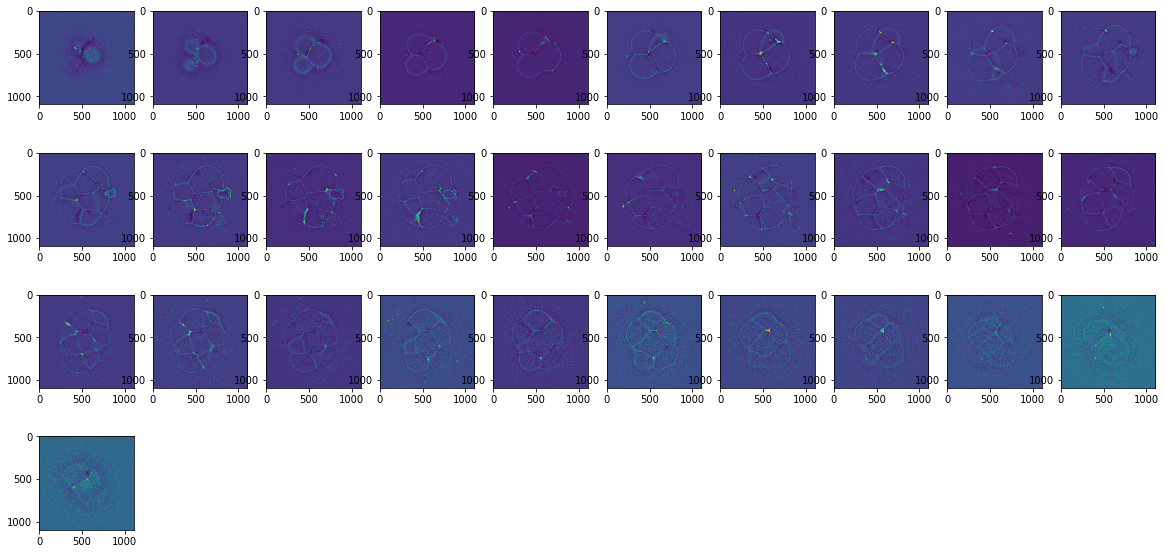

In [7]:
#Plot when 3D Kernel was used
cols = 10
plt.figure(figsize = (20,10))

for j in range(0, TotalTimePoints):
        plt.subplot(TotalTimePoints/cols + 1 , cols, j + 1 )      
        plt.imshow(MedianThreeDimage[j,:])

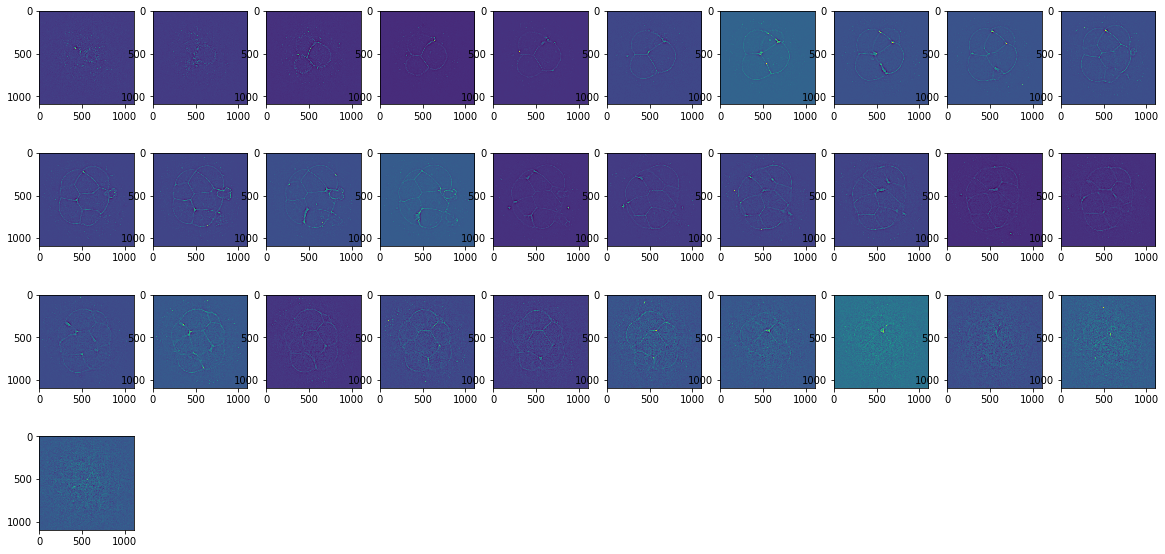

In [8]:
#Plot when 2D Kernel was used
cols = 10
plt.figure(figsize = (20,10))
for j in range(0, TotalTimePoints):
        plt.subplot(TotalTimePoints/cols + 1 , cols, j + 1 )      
        plt.imshow(TwoDMedianThreeDimage[j,:])

# Always a good idea to Normalize images before doing morphological operations that depend on the image intensity

1) The percentile based normalization code is taken from csbdeep repo and added as a function in the utils directory which we imported in the first cell

In [9]:
for j in range(0, TotalTimePoints):
  MedianThreeDimage[j,:] = NormalizeFloat(MedianThreeDimage[j,:], 1, 99.8)
  TwoDMedianThreeDimage[j,:] = NormalizeFloat(TwoDMedianThreeDimage[j,:], 1, 99.8)

In [10]:
#Save the Preprocessed images as ImageJ compatiable tiff files
save_tiff_imagej_compatible((resultsdir + "Blur" + '.tif') , MedianThreeDimage, axes)
save_tiff_imagej_compatible((resultsdir + "2DBlur" + '.tif') ,TwoDMedianThreeDimage, axes)

/Users/aimachine/BioPython/utils.py:181: UserWarning: Converting data type from 'float64' to ImageJ-compatible 'float32'.
  warnings.warn("Converting data type from '%s' to ImageJ-compatible '%s'." % (t, np.dtype(t_new)))
/Users/aimachine/BioPython/utils.py:84: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  x = x[slices]


# Do Distance transform on 3D and 2D slice by slice blurred image

In [ ]:
#Make Binary image using Otsu threshold by first enhancing the edges using canny edge detection
TotalTimePoints = BlurredThreeDimage.shape[0]
ThreeDedge= np.zeros([BlurredThreeDimage.shape[0],BlurredThreeDimage.shape[1], BlurredThreeDimage.shape[2]])
TwoDThreeDedge = np.zeros([BlurredThreeDimage.shape[0],BlurredThreeDimage.shape[1], BlurredThreeDimage.shape[2]])
ThreeDbinary = np.zeros([BlurredThreeDimage.shape[0],BlurredThreeDimage.shape[1], BlurredThreeDimage.shape[2]]) 
TwoDThreeDbinary = np.zeros([BlurredThreeDimage.shape[0],BlurredThreeDimage.shape[1], BlurredThreeDimage.shape[2]]) 
ThreeDdistance = np.zeros([BlurredThreeDimage.shape[0],BlurredThreeDimage.shape[1], BlurredThreeDimage.shape[2]]) 
TwoDBlurThreeDdistance = np.zeros([BlurredThreeDimage.shape[0],BlurredThreeDimage.shape[1], BlurredThreeDimage.shape[2]]) 


for j in range(0, TotalTimePoints):
 ThreeDedge[j,:] = canny(BlurredThreeDimage[j,:], sigma = 0.1)

 ThreeDthresh = threshold_mean(ThreeDedge[j,:])
 ThreeDbinary[j,:] = ThreeDedge[j,:] > ThreeDthresh
 ThreeDbinary[j,:] = binary_dilation(ThreeDbinary[j,:])
 ThreeDbinary[j,:] = binary_fill_holes(ThreeDbinary[j,:]) 


 TwoDThreeDedge[j,:] = canny(TwoDBlurredThreeDimage[j,:], sigma = 0.1)

 TwoDThreeDthresh = threshold_mean(TwoDThreeDedge[j,:])
 TwoDThreeDbinary[j,:] = TwoDThreeDedge[j,:] > TwoDThreeDthresh
 TwoDThreeDbinary[j,:] = binary_dilation(TwoDThreeDbinary[j,:])
 TwoDThreeDbinary[j,:] = binary_fill_holes(TwoDThreeDbinary[j,:])     
    

 #Do the distance transform and compare the two Blurring methods
 ThreeDdistance[j,:] = ndi.distance_transform_edt(np.logical_not((ThreeDbinary[j,:].astype('uint8'))))
 TwoDBlurThreeDdistance[j,:] = ndi.distance_transform_edt(np.logical_not((TwoDThreeDbinary[j,:].astype('uint8'))))  


In [ ]:
#Save Binaries
save_tiff_imagej_compatible((resultsdir + "Binary" + '.tif') ,  ThreeDbinary, axes)
save_tiff_imagej_compatible((resultsdir + "2DBlurBinary" + '.tif') ,TwoDThreeDbinary, axes)

In [ ]:
cols = 10
plt.figure(figsize = (20,10))
TotalTimePoints = ThreeDdistance.shape[0]
for j in range(0, TotalTimePoints):
        plt.subplot(TotalTimePoints/cols + 1 , cols, j + 1 )      
        plt.imshow((ThreeDdistance[j,:]) , cmap=plt.cm.gray)

In [ ]:
cols = 10
plt.figure(figsize = (20,10))
TotalTimePoints = TwoDBlurThreeDdistance.shape[0]
for j in range(0, TotalTimePoints):
        plt.subplot(TotalTimePoints/cols + 1 , cols, j + 1 )      
        plt.imshow((TwoDBlurThreeDdistance[j,:]), cmap=plt.cm.gray)

In [ ]:

#Save the slice by slice distance transformed image in results directory
save_tiff_imagej_compatible((resultsdir + "DistTransform" + '.tif') ,  ThreeDdistance, axes)
save_tiff_imagej_compatible((resultsdir + "2DBlurDistTransform" + '.tif') ,TwoDBlurThreeDdistance, axes)

# Trying 3D watershed

In [ ]:
labels = WatershedImage(ThreeDdistance, 3,3,3 )


In [ ]:
cols = 10
plt.figure(figsize = (20,10))
TotalTimePoints = labels.shape[0]
for j in range(0, TotalTimePoints):
        plt.subplot(TotalTimePoints/cols + 1 , cols, j + 1 )      
        plt.imshow(labels[j,:], cmap=plt.cm.gray)

In [ ]:
labels_second = WatershedImageMarker(TwoDBlurThreeDdistance,TwoDThreeDbinary, 3,3,3 )


In [ ]:
cols = 10
plt.figure(figsize = (20,10))
TotalTimePoints = labels_second.shape[0]
for j in range(0, TotalTimePoints):
        plt.subplot(TotalTimePoints/cols + 1 , cols, j + 1 )      
        plt.imshow(labels_second[j,:], cmap=plt.cm.gray)

In [ ]:
#Save the slice by slice distance transformed image in results directory
save_tiff_imagej_compatible((resultsdir + "Watershed" + '.tif') ,  labels, axes)
save_tiff_imagej_compatible((resultsdir + "2DBlurWatershed" + '.tif') ,labels_second, axes)

# Trying 2D watershed

In [ ]:

labels = np.zeros([BlurredThreeDimage.shape[0],BlurredThreeDimage.shape[1], BlurredThreeDimage.shape[2]])
for j in range(0, TotalTimePoints):
 labels[j,:] = WatershedImage(ThreeDdistance[j,:], 3,3 )  
 

In [ ]:
cols = 10
plt.figure(figsize = (20,10))
TotalTimePoints = labels.shape[0]
for j in range(0, TotalTimePoints):
        plt.subplot(TotalTimePoints/cols + 1 , cols, j + 1 )      
        plt.imshow(labels[j,:], cmap=plt.cm.gray)

In [ ]:

labels_second = np.zeros([BlurredThreeDimage.shape[0],BlurredThreeDimage.shape[1], BlurredThreeDimage.shape[2]])
for j in range(0, TotalTimePoints):
 labels_second[j,:] = WatershedImage(TwoDBlurThreeDdistance[j,:], 3,3 )  


In [ ]:
save_tiff_imagej_compatible((resultsdir + "TwoDimensionalWatershed" + '.tif') ,  labels, axes)
save_tiff_imagej_compatible((resultsdir + "2DBlurTwoDimensionalWatershed" + '.tif') ,  labels_second, axes)